# Imports

In [45]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTENC, SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Make your model

In [ ]:
# Explorer le Dataset

data = pd.read_csv('conversion_data_train.csv')
data = data.loc[data['age']<80,:]
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Choose variables to use in the model, and create train and test sets

In [ ]:
features_list = list(data.columns)
features_list.remove('converted')
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [ ]:
# Division du dataset en ensemble d'entraînement et de test
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



# Preprocessing

In [5]:
print("Encoding categorical features and standardizing numerical features...")

numeric_features = features_list.copy()
numeric_features.remove("country")
numeric_features.remove("new_user")
numeric_features.remove("source")
categorical_features = ["country", "new_user", "source"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


# PART 1 : BASELINE MODEL
*Objectif : Établir une performance de référence avec la variable la plus prédictive*


# Models

## Baseline

In [ ]:
features_list_baseline = ['total_pages_visited']
X_baseline = data.loc[:, features_list_baseline]
X_train_baseline, X_test_baseline, Y_train_baseline, Y_test_baseline = train_test_split(X_baseline, Y, test_size=0.1, stratify=Y, random_state=0)

numeric_transformer_baseline = StandardScaler()
X_train_baseline = numeric_transformer_baseline.fit_transform(X_train_baseline)
X_test_baseline = numeric_transformer_baseline.transform(X_test_baseline)

baseline = LogisticRegression()
baseline.fit(X_train_baseline, Y_train_baseline)
Y_train_pred_baseline = baseline.predict(X_train_baseline)
Y_test_pred_baseline = baseline.predict(X_test_baseline)
print("f1-score on train set : ", f1_score(Y_train_baseline, Y_train_pred_baseline))
print("f1-score on test set : ", f1_score(Y_test_baseline, Y_test_pred_baseline))

f1-score on train set :  0.6950136373172949
f1-score on test set :  0.6961394769613948


# Mon modèle baseline avec seulement la variable total_pages_visited atteint un F1-score de 69.6% sur le test set. C'est cohérent avec le template Jedha qui obtenait 70.6%. J'observe que les performances train/test sont très proches (69.5% vs 69.6%), ce qui indique un modèle équilibré sans sur-apprentissage."
"Cette performance de référence va maintenant me permettre de mesurer l'amélioration apportée par l'utilisation de toutes les variables et des algorithmes plus sophistiqués."

---
#  PART 2 : OPTIMISATION F1-SCORE
*Objectif : Améliorer les performances avec tous les features et hyperparameter tuning*

# Other models with grid search

In [ ]:
# Logistic Regression avec GridSearch 
print("GridSearch LogisticRegressionCV en cours...")

logreg = LogisticRegressionCV(penalty='l2', random_state=42) 
params = {
    'Cs': [5, 10, 15], 
    'class_weight': [
        None,
        {0: 1, 1: 1.3},
        {0: 1, 1: 1.5},
        'balanced'
    ]
}

gridsearch = GridSearchCV(logreg, scoring="f1", param_grid=params, cv=5, verbose=2)
gridsearch.fit(X_train, Y_train)

print("...Done.")
print("Best Parameters:", gridsearch.best_params_)
print("Best Score:", gridsearch.best_score_)

Y_train_pred = gridsearch.predict(X_train)
Y_test_pred = gridsearch.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

GridSearch LogisticRegressionCV en cours...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ............................Cs=5, class_weight=None; total time=   1.4s
[CV] END ............................Cs=5, class_weight=None; total time=   1.5s
[CV] END ............................Cs=5, class_weight=None; total time=   1.4s
[CV] END ............................Cs=5, class_weight=None; total time=   1.3s
[CV] END ............................Cs=5, class_weight=None; total time=   1.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.2s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.3s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.4s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.2s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.2s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   2.2s
[CV]

In [ ]:
# RandomForest
print("Test RandomForest avec GridSearch...")

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [40, 50],
    'max_depth': [10, 20],
    'min_samples_split': [10, 20, 30],
    'class_weight': [None, 'balanced', {0: 1, 1: 1.5}]
}

grid_search_rf = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv=3, 
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, Y_train)

print("...Done.")
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)

Y_train_pred_rf = grid_search_rf.predict(X_train)
Y_test_pred_rf = grid_search_rf.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred_rf))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred_rf))

Test RandomForest avec GridSearch...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
...Done.
Best Parameters: {'class_weight': {0: 1, 1: 1.5}, 'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 40}
Best Score: 0.7640810795244316
f1-score on train set :  0.7787964876033058
f1-score on test set :  0.764294049008168


In [ ]:
# Test XGBoost avec calcul automatique du ratio
print("Test XGBoost avec GridSearch...")

weight_ratio = float(len(Y_train[Y_train == 0]))/float(len(Y_train[Y_train == 1]))
print(f"Ratio des classes calculé : {weight_ratio:.2f}")

xgb = XGBClassifier(random_state=42, eval_metric='logloss')

param_grid_xgb = {
    'max_depth': [3, 6, 8],
    'min_child_weight': [2, 4, 6],
    'n_estimators': [50, 100],
    'scale_pos_weight': [weight_ratio, 1, 3]
}

grid_search_xgb = GridSearchCV(
    xgb, 
    param_grid_xgb, 
    cv=3, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, Y_train)

print("...Done.")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score:", grid_search_xgb.best_score_)

Y_train_pred_xgb = grid_search_xgb.predict(X_train)
Y_test_pred_xgb = grid_search_xgb.predict(X_test)

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred_xgb))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred_xgb))

Test XGBoost avec GridSearch...
Ratio des classes calculé : 30.01
Fitting 3 folds for each of 54 candidates, totalling 162 fits
...Done.
Best Parameters: {'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 50, 'scale_pos_weight': 1}
Best Score: 0.7632422784787377
f1-score on train set :  0.7709735456786833
f1-score on test set :  0.7610513739545998


In [ ]:
# Test Voting Classifier
print("Test Voting Classifier...")

from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[
        ("logistic", LogisticRegressionCV(Cs=[15], penalty='l2', class_weight={0: 1, 1: 1.5}, random_state=42)), 
        ("tree", RandomForestClassifier(class_weight={0: 1, 1: 1.5}, max_depth=10, min_samples_split=30, n_estimators=40, random_state=42)), 
        ("XGboosting", XGBClassifier(max_depth=6, min_child_weight=4, n_estimators=50, scale_pos_weight=1, random_state=42, eval_metric='logloss'))
    ],
    voting="soft",
)

voting.fit(X_train, Y_train)

Y_train_pred = voting.predict(X_train)
Y_test_pred = voting.predict(X_test)

print("...Done.")
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

# Best model

##  FEATURE ENGINEERING AVANCÉ
*Création de nouvelles variables pour améliorer la prédiction*

**Variables combinées (insights EDA) :**
- `Age_per_Pages` : Ratio âge/pages visitées  
- `Age_x_NewUser` : Interaction âge × type utilisateur

**Transformations mathématiques :**
- Log, racine, carré, inverse sur `total_pages_visited` et `age`

**Variables catégorielles dérivées :**
- `high_pages` : Seuil >10 pages visitées
- `young_user` : Seuil <30 ans

In [18]:
# Best model with feature engineering
data_features = data.copy()

# Variables combinées (basées sur insights EDA)
data_features['Age_per_Pages'] = data_features['age'] / data_features['total_pages_visited']
data_features['Age_x_NewUser'] = data_features['age'] * data_features['new_user'].replace({0:0.5, 1:1})

# Transformations sur total_pages_visited (variable la plus importante)
data_features["log_total_pages_visited"] = np.log(data_features["total_pages_visited"])   
data_features["sqrt_total_pages_visited"] = np.sqrt(data_features["total_pages_visited"])   
data_features["sq_total_pages_visited"] = data_features["total_pages_visited"] ** 2
data_features["inv_total_pages_visited"] = 1 / data_features["total_pages_visited"]

# Transformations sur age (variable importante)
data_features["log_age"] = np.log(data_features["age"])   
data_features["sqrt_age"] = np.sqrt(data_features["age"])   
data_features["sq_age"] = data_features["age"] ** 2
data_features["inv_age"] = 1 / data_features["age"]

# Variables catégorielles dérivées
data_features['high_pages'] = (data_features['total_pages_visited'] > 10).astype(int)
data_features['young_user'] = (data_features['age'] < 30).astype(int)

data_features.head()

,country,age,new_user,source,total_pages_visited,converted,Age_per_Pages,Age_x_NewUser,log_total_pages_visited,sqrt_total_pages_visited,sq_total_pages_visited,inv_total_pages_visited,log_age,sqrt_age,sq_age,inv_age,high_pages,young_user
0,China,22,1,Direct,2,0,11.000000,22.0,0.693147,1.414214,4,0.500000,3.091042,4.690416,484,0.045455,0,1
1,UK,21,1,Ads,3,0,7.000000,21.0,1.098612,1.732051,9,0.333333,3.044522,4.582576,441,0.047619,0,1
2,Germany,20,0,Seo,14,1,1.428571,10.0,2.639057,3.741657,196,0.071429,2.995732,4.472136,400,0.050000,1,1
3,US,23,1,Seo,3,0,7.666667,23.0,1.098612,1.732051,9,0.333333,3.135494,4.795832,529,0.043478,0,1
4,US,28,1,Direct,3,0,9.333333,28.0,1.098612,1.732051,9,0.333333,3.332205,5.291503,784,0.035714,0,1


In [19]:
# Choix des variables avec Feature Engineering
features_list_feateng = list(data_features.columns)
features_list_feateng.remove('converted')
target_variable = 'converted'

X_feateng = data_features.loc[:, features_list_feateng]
Y_feateng = data_features.loc[:, target_variable]

print('Explanatory variables : ', X_feateng.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'Age_per_Pages', 'Age_x_NewUser', 'log_total_pages_visited',
       'sqrt_total_pages_visited', 'sq_total_pages_visited',
       'inv_total_pages_visited', 'log_age', 'sqrt_age', 'sq_age', 'inv_age',
       'high_pages', 'young_user'],
      dtype='object')



In [20]:
# Division du dataset en ensemble d'entraînement et de test
print("Dividing into train and test sets...")
X_train_feateng, X_test_feateng, Y_train_feateng, Y_test_feateng = train_test_split(
    X_feateng, Y_feateng, test_size=0.1, stratify=Y_feateng, random_state=0
)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [ ]:
print("Encoding categorical features and standardizing numerical features...")

X_train_feateng['country'] = X_train_feateng['country'].astype("category")
X_train_feateng['new_user'] = X_train_feateng['new_user'].astype("category")
X_train_feateng['source'] = X_train_feateng['source'].astype("category")
X_test_feateng['country'] = X_test_feateng['country'].astype("category")
X_test_feateng['new_user'] = X_test_feateng['new_user'].astype("category")
X_test_feateng['source'] = X_test_feateng['source'].astype("category")

numeric_features_feateng = features_list_feateng.copy()
numeric_features_feateng.remove("country")
numeric_features_feateng.remove("new_user") 
numeric_features_feateng.remove("source")
categorical_features = ["country", "new_user", "source"]

preprocessor_feateng = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_feateng),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train_feateng = preprocessor_feateng.fit_transform(X_train_feateng)
X_test_feateng = preprocessor_feateng.transform(X_test_feateng)

print("...Done")

Encoding categorical features and standardizing numerical features...
...Done


In [ ]:
print("Train model...")
classifier_feateng = LogisticRegression(random_state=42)
classifier_feateng.fit(X_train_feateng, Y_train_feateng)
print("...Done.")

Train model...
...Done.


In [ ]:
print("Predictions on training set...")
Y_train_pred_feateng = classifier_feateng.predict(X_train_feateng)
print("...Done.")
print(Y_train_pred_feateng)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
print("Predictions on test set...")
Y_test_pred_feateng = classifier_feateng.predict(X_test_feateng)
print("...Done.")
print(Y_test_pred_feateng)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [25]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train_feateng, Y_train_pred_feateng))
print("f1-score on test set : ", f1_score(Y_test_feateng, Y_test_pred_feateng))

f1-score on train set :  0.7631279684259816
f1-score on test set :  0.7671068427370948


In [ ]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train_feateng, Y_train_pred_feateng))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test_feateng, Y_test_pred_feateng))
print()

Confusion matrix on train set : 
[[246875    985]
 [  2556   5704]]

Confusion matrix on test set : 
[[27431   109]
 [  279   639]]



## Sélection de features 


In [29]:
print("Sélection des 10 meilleures features...")

classifier = LogisticRegression()
feature_selector = SequentialFeatureSelector(classifier, n_features_to_select=10) 
feature_selector.fit(X_train_feateng, Y_train_feateng)

column_names = []
for name, step, features_l in preprocessor_feateng.transformers_: 
    if name == 'num': 
        features = features_l 
    else: 
        features = step.get_feature_names_out() 
    column_names.extend(features) 

print("According to the forward selection algorithm, the following features should be kept: ")
for i in range(len(feature_selector.support_)):
    if feature_selector.support_[i] == True:
        print(column_names[i])

print("...Done.")

Sélection des 10 meilleures features...
According to the forward selection algorithm, the following features should be kept: 
age
total_pages_visited
Age_x_NewUser
log_total_pages_visited
sq_total_pages_visited
log_age
country_Germany
country_UK
country_US
new_user_1
...Done.


In [ ]:
# Modèle avec features sélectionnées
print("Entraînement avec les 10 features sélectionnées...")

X_train_selected = feature_selector.transform(X_train_feateng)
X_test_selected = feature_selector.transform(X_test_feateng)

classifier_selected = LogisticRegression(random_state=42)
classifier_selected.fit(X_train_selected, Y_train_feateng)

Y_train_pred_selected = classifier_selected.predict(X_train_selected)
Y_test_pred_selected = classifier_selected.predict(X_test_selected)

print("f1-score on train set : ", f1_score(Y_train_feateng, Y_train_pred_selected))
print("f1-score on test set : ", f1_score(Y_test_feateng, Y_test_pred_selected))
print("...Done.")

Entraînement avec les 10 features sélectionnées...
f1-score on train set :  0.7618983777986326
f1-score on test set :  0.7653429602888087
...Done.


In [31]:
params = {
    'Cs': [5, 10, 15], 
    'class_weight': [
        None,
        {0: 1, 1: 1.3},
        {0: 1, 1: 1.5},
        'balanced'
    ]
}

gridsearch_selected = GridSearchCV(logreg, param_grid=params, scoring='precision', cv=3, verbose=2)
gridsearch_selected.fit(X_train_selected, Y_train_feateng)

print("Best Parameters:", gridsearch_selected.best_params_)
print("Best Score:", gridsearch_selected.best_score_)

Y_train_pred_final = gridsearch_selected.predict(X_train_selected)
Y_test_pred_final = gridsearch_selected.predict(X_test_selected)

print("f1-score on train set : ", f1_score(Y_train_feateng, Y_train_pred_final))
print("f1-score on test set : ", f1_score(Y_test_feateng, Y_test_pred_final))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ............................Cs=5, class_weight=None; total time=   1.7s
[CV] END ............................Cs=5, class_weight=None; total time=   1.8s
[CV] END ............................Cs=5, class_weight=None; total time=   1.7s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   1.9s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   2.0s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.3}; total time=   1.9s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   2.1s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   1.8s
[CV] END ..................Cs=5, class_weight={0: 1, 1: 1.5}; total time=   1.9s
[CV] END ........................Cs=5, class_weight=balanced; total time=   2.6s
[CV] END ........................Cs=5, class_weight=balanced; total time=   2.7s
[CV] END ........................Cs=5, class_wei

In [ ]:
# SMOTE 
print("Application de SMOTE sur les features sélectionnées...")

smote = SMOTENC(categorical_features=[6,7,8,9], sampling_strategy=0.05, random_state=42)

X_train_smote, Y_train_smote = smote.fit_resample(X_train_selected, Y_train_feateng)

print('Original dataset shape:', Counter(Y_train_feateng))
print('Resampled dataset shape:', Counter(Y_train_smote))

classifier_smote = LogisticRegression(random_state=42)
classifier_smote.fit(X_train_smote, Y_train_smote)

Y_train_pred_smote = classifier_smote.predict(X_train_selected)
Y_test_pred_smote = classifier_smote.predict(X_test_selected)

print("f1-score on train set : ", f1_score(Y_train_feateng, Y_train_pred_smote))
print("f1-score on test set : ", f1_score(Y_test_feateng, Y_test_pred_smote))
print("...Done.")

Application de SMOTE sur les features sélectionnées...
Original dataset shape: Counter({0: 247860, 1: 8260})
Resampled dataset shape: Counter({0: 247860, 1: 12393})
f1-score on train set :  0.7703495789742281
f1-score on test set :  0.7655447803764974
...Done.


---
#  PART 3 : PRÉDICTIONS FINALES
*Objectif : Prédictions sur data_test.csv pour soumission leaderboard*

In [ ]:
# Train multiple models on all data and use them to make predictions

X = np.append(X_train, X_test, axis=0)
Y = np.append(Y_train, Y_test)

logreg = LogisticRegressionCV(Cs=[5], penalty='l2', class_weight={0: 1, 1: 1.5}, random_state=42).fit(X, Y)
RFC = RandomForestClassifier(class_weight={0: 1, 1: 1.5}, max_depth=10, min_samples_split=30, n_estimators=40, random_state=42).fit(X, Y)
XGBC = XGBClassifier(max_depth=6, min_child_weight=4, n_estimators=50, scale_pos_weight=1, random_state=42, eval_metric='logloss').fit(X, Y)

sm = SMOTENC(categorical_features=[2,3,4,5,6,7], sampling_strategy=0.05)
X_resampled, Y_resampled = sm.fit_resample(X, Y)
xgbc_smote = XGBClassifier(max_depth=6, min_child_weight=8, n_estimators=25).fit(X_resampled, Y_resampled)

data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels):', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same as the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

print("Convert pandas DataFrames to arrays...")
print("...Done")

print(X_without_labels.head())

print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)

print("...Done")
print(X_without_labels[0:5,:])

data = {
    'converted': logreg.predict(X_without_labels)
}
Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_TON_NOM-logreg.csv', index=False)

data = {
    'converted': RFC.predict(X_without_labels)
}
Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_TON_NOM-RFC.csv', index=False)

data = {
    'converted': XGBC.predict(X_without_labels)
}
Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_TON_NOM-XGBC.csv', index=False)

data = {
    'converted': xgbc_smote.predict(X_without_labels)
}
Y_predictions = pd.DataFrame(columns=['converted'], data=data)
Y_predictions.to_csv('conversion_data_test_predictions_TON_NOM-xgbc_smote.csv', index=False)

Prediction set (without labels): (31620, 5)
Convert pandas DataFrames to arrays...
...Done
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
Encoding categorical features and standardizing numerical features...
...Done
[[-0.31000438  3.33049128  0.          1.          0.          0.
   0.          1.        ]
 [-1.03592414  0.03829244  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17394213 -1.15887077  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17394213  0.33758325  0.          0.          1.          1.
   0.          0.        ]
 [-0.67296426 -0.56028917  0.          0.          0.          0.
   0.          1.        ]]


---
#  PART 4 : ANALYSE + RECOMMANDATIONS BUSINESS
*Objectif : Comprendre le modèle et proposer des actions concrètes*

# Conclusion

In [ ]:
best_model_analysis = LogisticRegressionCV(Cs=[5], penalty='l2', class_weight={0: 1, 1: 1.5}, random_state=42)
best_model_analysis.fit(X_train, Y_train)

Y_train_pred = best_model_analysis.predict(X_train)
Y_test_pred = best_model_analysis.predict(X_test)

In [ ]:
print("Model trained successfully!")
print("Train predictions shape:", Y_train_pred.shape)
print("Test predictions shape:", Y_test_pred.shape)
print("F1-score on test:", f1_score(Y_test, Y_test_pred))

Model trained successfully!
Train predictions shape: (256120,)
Test predictions shape: (28458,)
F1-score on test: 0.766951566951567


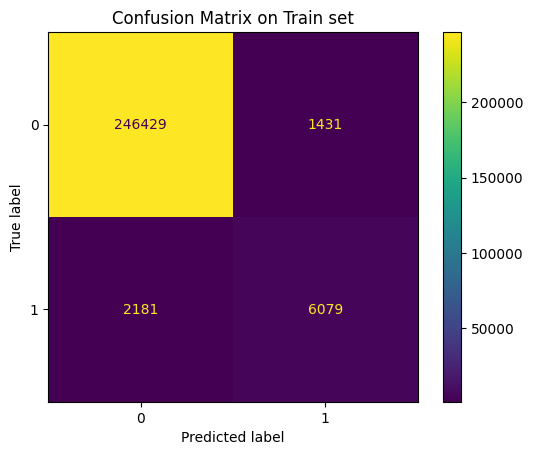

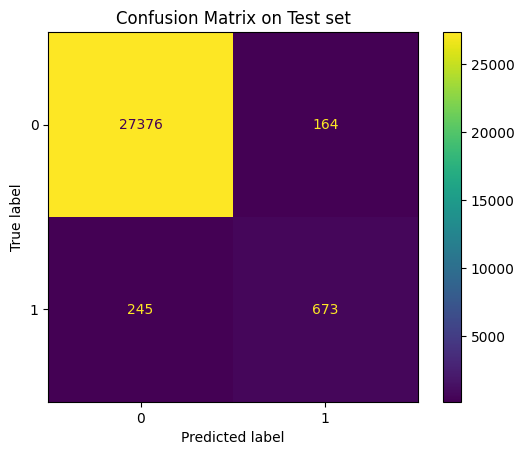

In [ ]:
_, ax = plt.subplots()
ax.set(title="Confusion Matrix on Train set")  
ConfusionMatrixDisplay.from_estimator(best_model_analysis, X_train, Y_train, ax=ax) 
plt.show()

_, ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set")  
ConfusionMatrixDisplay.from_estimator(best_model_analysis, X_test, Y_test, ax=ax)  
plt.show()

In [43]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     27540
           1       0.80      0.73      0.77       918

    accuracy                           0.99     28458
   macro avg       0.90      0.86      0.88     28458
weighted avg       0.99      0.99      0.99     28458



f:\projet_certif_19_06_2025_livrable\Projet_Conversion_rate_challenge\.venv\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


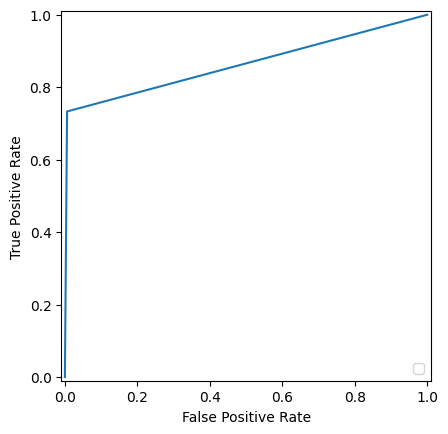

In [46]:
# ROC curve

fpr, tpr, _ = roc_curve(Y_test, Y_test_pred, pos_label=logreg.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [47]:
# Analysing the best model's parameters

column_names = []
for name, pipeline, features_list in preprocessor.transformers_: 
    if name == 'num': 
        features = features_list 
    else: 
        features = pipeline.get_feature_names_out()   
    column_names.extend(features) 
        
coefs = pd.DataFrame(index=column_names, data=best_model_analysis.coef_.transpose(), columns=["coefficients"])
feature_importance = coefs.sort_values(by='coefficients', key=abs)

print(feature_importance)

                     coefficients
source_Seo              -0.023725
source_Direct           -0.199726
age                     -0.618473
new_user_1              -1.710519
total_pages_visited      2.542687
country_US               3.111530
country_UK               3.443517
country_Germany          3.718527


In [50]:
import plotly.express as px

fig = px.bar(feature_importance, orientation='h')
fig.update_layout(showlegend=False, 
                  margin={'l': 120}, title_x=0.5,
                  title_text="Features importance of the best model (Logistic Regression)")
fig.show()

## Recommandations Business

### **Analyzing the coefficients and interpreting the result**

L'analyse des coefficients révèle que **total_pages_visited (+2.54)** est le facteur le plus important pour la conversion, suivi des pays Germany (+3.72), UK (+3.44) et US (+3.11), tandis que les nouveaux utilisateurs (-1.71) convertissent moins bien.

### **Perspectives d'amélioration :**
* Cibler prioritairement l'Allemagne, UK et USA - marchés les plus convertisseurs
* Améliorer l'onboarding des nouveaux utilisateurs et inciter à visiter plus de pages
* Tester des thresholds différents de 0.5 pour optimiser les prédictions